# Here is an example for 2D acoustic full waveform inversion

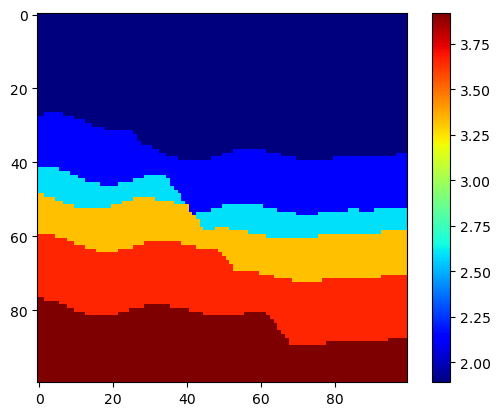

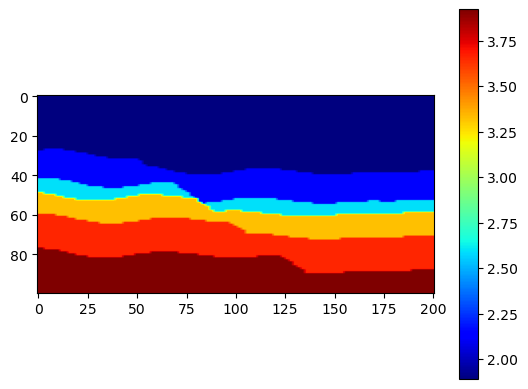

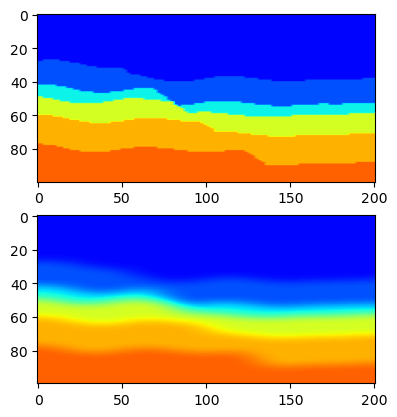

In [1]:
from pywave import pfwi #pip install git+https://github.com/chenyk1990/pywave
from pyseistr import smooth,cseis #pip install git+https://github.com/aaspip/pyseistr

import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import interpolate
import warnings
warnings.simplefilter("ignore")

## Extract on velocity sample from GeoFWI database
from geofwi import get_vel
vel=get_vel(layer=6,mode='fault',datapath='../data',indx=200)/1000.0 #turn into the last sample of the last type
import matplotlib.pyplot as plt
plt.imshow(vel,cmap=plt.jet());plt.colorbar();
plt.show()

[nz,nx]=vel.shape;

nx2=201;
nz2=100;

x1=np.arange(nx)*0.02;
z1=np.arange(nz)*0.02;
x2=np.arange(nx2)*0.01;
z2=np.arange(nz2)*0.02;
f = interpolate.interp2d (x1, z1, vel)
vel = f(x2, z2)
plt.imshow(vel,cmap=plt.jet());plt.colorbar();
plt.show()

## obtain start velocity
vel_s = smooth(vel,[5,20,1]);
q=np.ones(vel.shape)*10000;
plt.subplot(2,1,1);
plt.imshow(vel, clim=[1.5,4.5]);
plt.subplot(2,1,2);
plt.imshow(vel_s, clim=[1.5,4.5]);
plt.show()


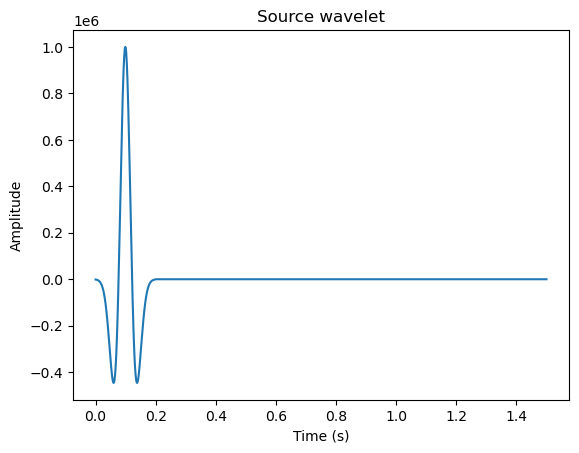

In [2]:
## wavelet
from pyseistr import ricker
nt=1501;
trace=np.zeros(nt);trace[99]=1000000;dt=0.001;
wav,tw=ricker(10,dt,0.2)
wavelet=np.convolve(trace,wav,mode='same');
t=np.linspace(0,(nt-1)*dt,nt);
plt.plot(t,wavelet);plt.xlabel('Time (s)');plt.ylabel('Amplitude');plt.title('Source wavelet');
plt.show()

## Setting up the parameter dictionary
mypar={'nz':100, 'nx':201, 'dz': 0.02, 'dx': 0.01, 'oz': 0, 'ox': 0, 'ns': 20, 'ds': 0.1,
		'nt': 1501, 'dt': 0.001, 'ot': 0, 'nb':30, 'coef': 0.005, 'acqui_type': 1, 
		'inv': 0, 'waterz': 0, 'onlysrc': True, 'onlyvel': 1, 'conv_error': 0.01, 'niter': 5}


start modeling in python
data flattening done in python
par: {'f0': 10, 'nb': 60, 'coef': 0.005, 'acqui_type': 1, 'interval': 1, 'ns': 20, 'ds': 0.1, 'os': 0.0, 'sz': 5, 'nx': 201, 'nz': 100, 'nr': 201, 'dr': 0.01, 'r0': 0, 'fhi': 500.0, 'flo': 0, 'onlysrc': True, 'onlyvel': 1, 'inv': 0, 'niter': 5, 'dz': 0.02, 'dx': 0.01, 'oz': 0, 'ox': 0, 'nt': 1501, 'dt': 0.001, 'ot': 0, 'waterz': 0, 'conv_error': 0.01}
len(pararray) 20


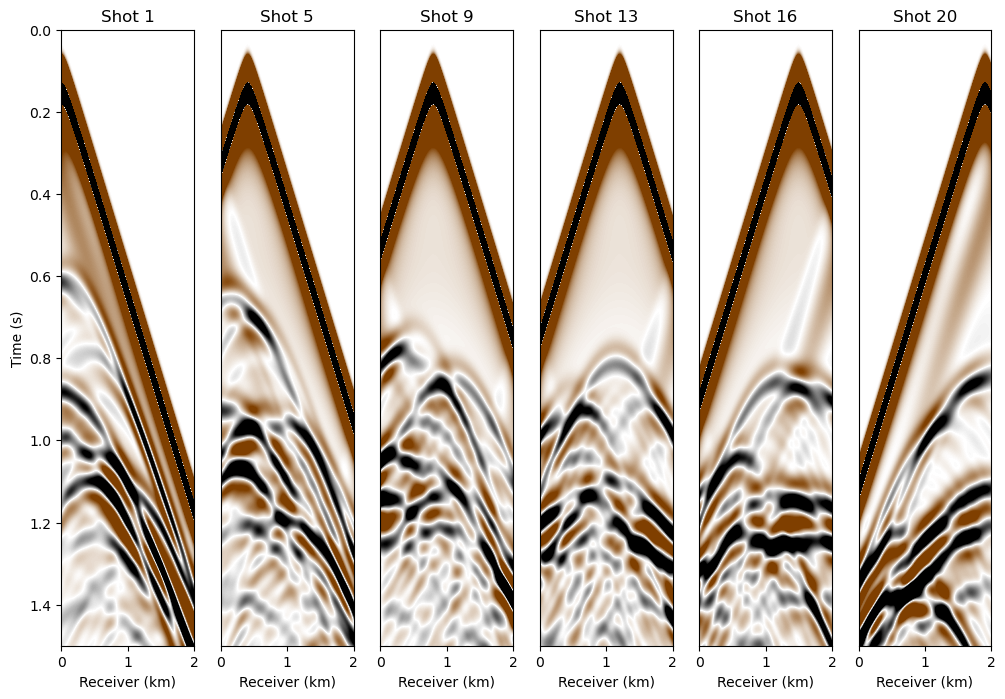

In [3]:
## Generate data from ground-truth velocity for FWI
mypar['nb']=60 #try different NB values
data,tmp,tmp,tmp,tmp=pfwi(vel,q,wavelet,src=None,data=None,mode=1,media=1,inv=0,verb=1,par=mypar);
np.save('fwi-datas-%d.npy'%mypar['ns'],data)

## Visualize data 
par=mypar
plt.figure(figsize=(12, 8))
plt.subplot(1,6,1);
plt.imshow(data[:,:,0],aspect='auto',clim=(-0.5,0.5), cmap=cseis(),extent=[0,par['dx']*(par['nx']-1),par['dt']*(par['nt']-1),0]);
plt.title("Shot 1"); plt.ylabel("Time (s)"); plt.xlabel("Receiver (km)"); 
plt.subplot(1,6,2);
plt.imshow(data[:,:,4],aspect='auto',clim=(-0.5,0.5), cmap=cseis(),extent=[0,par['dx']*(par['nx']-1),par['dt']*(par['nt']-1),0]);
plt.title("Shot 5"); plt.gca().set_yticks([]); plt.xlabel("Receiver (km)"); 
plt.subplot(1,6,3);
plt.imshow(data[:,:,8],aspect='auto',clim=(-0.5,0.5), cmap=cseis(),extent=[0,par['dx']*(par['nx']-1),par['dt']*(par['nt']-1),0]);
plt.title("Shot 9"); plt.gca().set_yticks([]); plt.xlabel("Receiver (km)"); 

plt.subplot(1,6,4);
plt.imshow(data[:,:,12],aspect='auto',clim=(-0.5,0.5), cmap=cseis(),extent=[0,par['dx']*(par['nx']-1),par['dt']*(par['nt']-1),0]);
plt.title("Shot 13"); plt.gca().set_yticks([]);plt.xlabel("Receiver (km)"); 
plt.subplot(1,6,5);
plt.imshow(data[:,:,15],aspect='auto',clim=(-0.5,0.5), cmap=cseis(),extent=[0,par['dx']*(par['nx']-1),par['dt']*(par['nt']-1),0]);
plt.title("Shot 16"); plt.gca().set_yticks([]); plt.xlabel("Receiver (km)"); 
plt.subplot(1,6,6);
plt.imshow(data[:,:,19],aspect='auto',clim=(-0.5,0.5), cmap=cseis(),extent=[0,par['dx']*(par['nx']-1),par['dt']*(par['nt']-1),0]);
plt.title("Shot 20"); plt.gca().set_yticks([]); plt.xlabel("Receiver (km)"); 

plt.show()


In [4]:
data.max()

20.98357

In [ ]:
## FWI
mypar['niter']=30;
data=np.load('fwi-datas-%d.npy'%mypar['ns'])
tmp,vinv,grad,tmp,tmp=pfwi(vel_s,q,wavelet,src=None,data=data,mode=2,media=1,inv=0,verb=0,par=mypar);




## Visualize FWI results
par=mypar;
plt.figure(figsize=(8, 10))
plt.subplot(4,1,1);
plt.imshow(vel,cmap=plt.jet(),aspect='auto',clim=(1.5, 4.5), extent=[0,par['dx']*(par['nx']-1),par['dz']*(par['nz']-1),0]); 
plt.title("Ground truth"); plt.ylabel("Depth (km)"); plt.gca().set_xticks([]);
plt.subplot(4,1,2);
plt.imshow(vel_s,aspect='auto',clim=(1.5, 4.5), extent=[0,par['dx']*(par['nx']-1),par['dz']*(par['nz']-1),0]); 
plt.title("Initial model"); plt.ylabel("Depth (km)"); plt.gca().set_xticks([]);
plt.subplot(4,1,3);
plt.imshow(vinv[:,:,int(par['niter']/2)],aspect='auto',clim=(1.5, 4.5), extent=[0,par['dx']*(par['nx']-1),par['dz']*(par['nz']-1),0]);
plt.title("%d Iterations"%int(par['niter']/2));plt.ylabel("Depth (km)"); plt.gca().set_xticks([]);
plt.subplot(4,1,4);
plt.imshow(vinv[:,:,par['niter']-1],aspect='auto',clim=(1.5, 4.5), extent=[0,par['dx']*(par['nx']-1),par['dz']*(par['nz']-1),0]);
plt.title("%d Iterations"%par['niter']); plt.ylabel("Depth (km)"); plt.xlabel("Lateral (km)"); 
plt.show()


